### Make some line data

In [1]:
import numpy as np
import pylab as plt

x = np.arange(0., 10., 0.1)
m = .5
b = .3
s = 1.
yt = m*x + b
y = np.random.randn(len(x))*s + yt

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
tf.reset_default_graph()

T = tf.float64
tx = tf.constant(x, dtype=T)
ty = tf.constant(y, dtype=T)
tm = tf.Variable(m, dtype=T)
tb = tf.Variable(b, dtype=T)
ts = tf.Variable(s, dtype=T)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.


### Write model

In [3]:
def model(x, m, b):
    return x * m + b

/home/oliver/.local/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


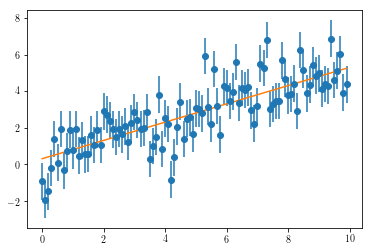

In [4]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    mod = session.run(model(tx,tm, tb))
    plt.errorbar(x, y, yerr = np.ones_like(x)*s, fmt='o')
    plt.plot(x, mod)
    plt.show()

### Write the likelihood function

In [5]:
def tf_log_like(x, y, m, b, s):
    model = m * x + b
    return -0.5 * tf.reduce_sum(((y-model)/s)**2. + tf.log(2.*np.pi*s**2.))

def tf_log_prob(x, y, m, b, s):
    model = m * x + b
    log_prior = -1.5 * tf.log(1.0 + tm**2.)
    log_like = -0.5 * tf.reduce_sum(((y-model)/s)**2. + tf.log(2.*np.pi*s**2.))
    log_prob = log_like + log_prior
    return log_prob

llike = tf_log_like(tx, ty, tm, tb, ts)
lprob = tf_log_prob(tx, ty, tm, tb, ts)

In [6]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    print("The log likelihood computed using tensorflow: {0}"
          .format(session.run(llike)))
    print("The log posterior computed using tensorflow: {0}"
      .format(session.run(lprob)))

The log likelihood computed using tensorflow: -149.73002231706295
The log posterior computed using tensorflow: -150.06473764403427


### Fit using HMC

In [17]:
# Initialize the HMC transition kernel.
hmc = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn = tf_log_prob,
        step_size = 0.0001,
        num_leapfrog_steps=2)

In [21]:
# Run the chain (with burn-in).
cstate = [tx, ty, tm, tb, ts]

samples, kernel_results = tfp.mcmc.sample_chain(
    num_results = 5000,
    num_burnin_steps = 5000,
    current_state = cstate, 
    kernel = hmc)

In [22]:
# Initialize all constructed variables.
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    samples_, kernel_results_ = session.run([samples, kernel_results])

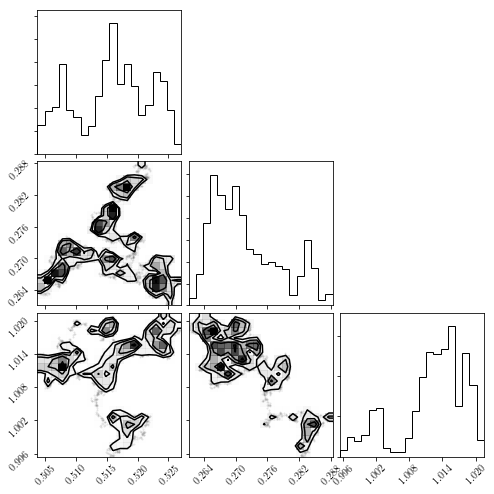

In [23]:
import corner
corner.corner(np.array(samples_[2:]).T)
plt.show()

In [30]:
np.array(samples_[2:]).shape

(3, 5000)